In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
from sklearn.cluster import KMeans
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm

C:\Users\Cyborg\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
df=pd.read_csv(r"C:\Users\Cyborg\Music\mueller_report.csv")

In [4]:
df.describe()

,page,line
count,19195.000000,19195.000000
mean,224.540141,23.744725
std,121.650416,14.235052
min,1.000000,1.000000
25%,120.000000,11.000000
50%,232.000000,23.000000
75%,326.000000,35.000000
max,448.000000,59.000000


In [5]:
print("Number of data points:",df.shape[0])

Number of data points: 19195


In [6]:
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

       page  line text
11        1    12  NaN
14        2     3  NaN
49        3    35  NaN
87        4    38  NaN
126       5    39  NaN
164       6    38  NaN
201       7    37  NaN
204       8     3  NaN
247       9    43  NaN
287      10    40  NaN
297      11    10  NaN
335      12    38  NaN
377      13    42  NaN
423      14    46  NaN
468      15    45  NaN
510      16    42  NaN
549      17    39  NaN
590      18    41  NaN
634      19    44  NaN
680      20    46  NaN
726      21    46  NaN
770      22    44  NaN
810      23    40  NaN
837      24    27  NaN
858      25    21  NaN
874      26    16  NaN
903      27    29  NaN
915      28    12  NaN
936      29    21  NaN
966      30    30  NaN
...     ...   ...  ...
18278   419    43  NaN
18320   420    42  NaN
18363   421    43  NaN
18403   422    40  NaN
18442   423    39  NaN
18482   424    40  NaN
18523   425    41  NaN
18551   426    28  NaN
18587   427    36  NaN
18623   428    36  NaN
18664   429    41  NaN
18704   430

In [7]:
df = df[pd.notnull(df['text'])]

In [8]:
print("Number of new data points:",df.shape[0])

Number of new data points: 18747


In [9]:
print("percentage of data to be used: ", 18747/19195, " (%)percentage")

percentage of data to be used:  0.9766605886949726  (%)percentage


In [11]:
len(df['text'][0])

26

In [12]:
df.head()

,page,line,text
0,1,1,U.S. Department of Justice
1,1,2,"AttarAe:,c\\'erlc Predtiet // Mtt; CeA1:ttiA"
2,1,3,Ma1:ertalPrn1:eetedUAder Fed. R. Crhtt. P. 6(e)
3,1,4,Report On The Investigation Into
4,1,5,Russian InterferenceIn The


In [13]:
# df['page'].value_counts()

In [14]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup


In [15]:
df['text'].head()

0                         U.S. Department of Justice
1       AttarAe:,c\\'erlc Predtiet // Mtt; CeA1:ttiA
2    Ma1:ertalPrn1:eetedUAder Fed. R. Crhtt. P. 6(e)
3                   Report On The Investigation Into
4                         Russian InterferenceIn The
Name: text, dtype: object

In [16]:
def decontracted(phrase):
# specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:

stopwords=set(["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])

#### Sentence Preprocessing

In [18]:
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(df['text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())


  4%|██▊                                                                         | 688/18747 [00:00<00:08, 2164.53it/s]C:\Users\Cyborg\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'. .'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\Cyborg\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
  6%|████▌                                                                      | 1130/18747 [00:00<00:08, 2182.58it/s]C:\Users\Cyborg\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\Cyborg\Anaconda3\lib\site-packages\bs4\__init__.py:219: 

In [19]:
preprocessed_reviews[10]

'march'

## Word Vectorizations

### Bag of Words Vectorizations

In [22]:
X=preprocessed_reviews[:]
# y=final['Score'][:]
# X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=42)
X_train=preprocessed_reviews[:13000]
X_test=preprocessed_reviews[13000 :]
bow = CountVectorizer()
X_train_bow=bow.fit_transform(X_train)
X_test_bow=bow.transform(X_test)

In [24]:
print("Train Bag of Words Shape", X_train_bow.shape)
print("Test Bag of Words Shape", X_test_bow.shape)

Train Bag of Words Shape (13000, 8053)
Test Bag of Words Shape (5747, 8053)


### K-Means Clustering

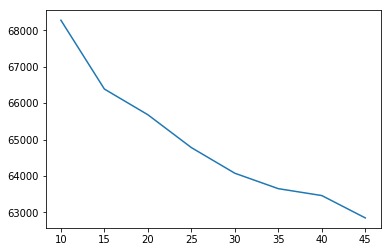

In [63]:
errors=[]
k_value=[10,15,20,25,30, 35, 40,45 ]
for i in k_value:
    kmeans = KMeans(n_clusters=i, random_state=0, n_jobs=-1)
    kmeans.fit(X_train_bow)
    pred=kmeans.predict(X_test_bow)
    errors.append(kmeans.inertia_)
plt.plot(k_value, errors)

30 seem to be an optimal number of cluster for the inertia metric considered

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
model=KMeans(n_clusters=30, n_jobs=-1)
z=bow.fit_transform(preprocessed_reviews)
model.fit(scaler.fit_transform(z.toarray()))

In [65]:
w=model.labels_

In [23]:
from wordcloud import WordCloud, STOPWORDS


In [67]:
set(w)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29}

In [68]:
feature_importances.head(15)

,importance
established canon statutory construction applied pecial force provisions would,8
attaraey wark pt asttet may cahtttih material prateetes uaser fee r crim p,7
lu ehfareefflefl tsehsitive les shs f lttst trestes ueeersihgly ih uhy,6
defense system iran russian planes buzzing u military assets middle east russian,5
nader george advi sor united arab emirates crown prin ce arranged,4
police officer tipped suspects issuance arrest warrants outsta nding,3
attarre wark prad ttet mtt cartttirmttterittlprateeted urd erfed r crim p,2
see e g matt zapotosky comey lays case trump obstructed justice washington,1
ruddy recalled told president strongly considering firing special counsel,1
sc ad donaldson notes,1


In [53]:
importance = feature_importances.groupby("importance")


In [69]:
feature_importances['importance'].value_counts()

1    18739
8        1
7        1
6        1
5        1
4        1
3        1
2        1
0        1
Name: importance, dtype: int64

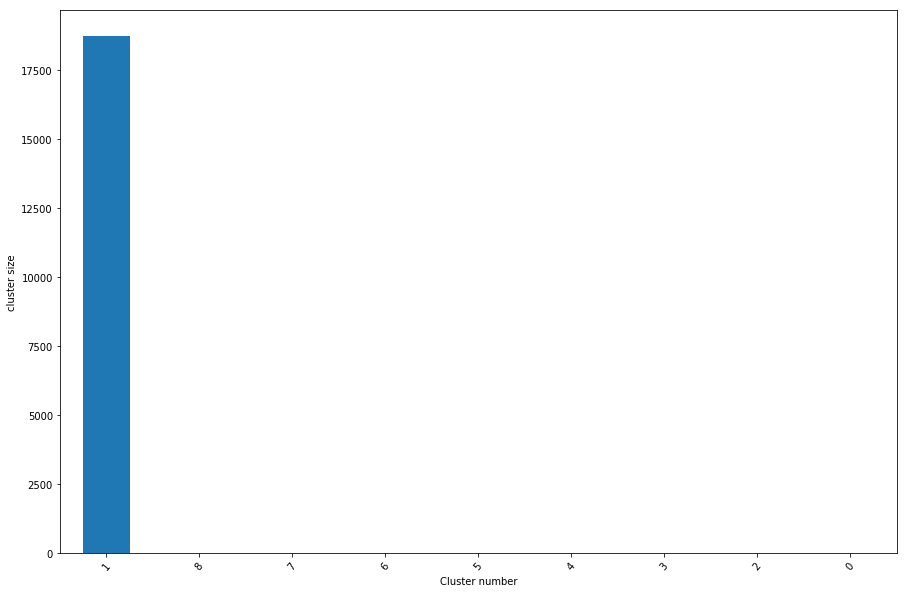

In [70]:
plt.figure(figsize=(15,10))
importance.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Cluster number")
plt.ylabel("cluster size")
plt.show()

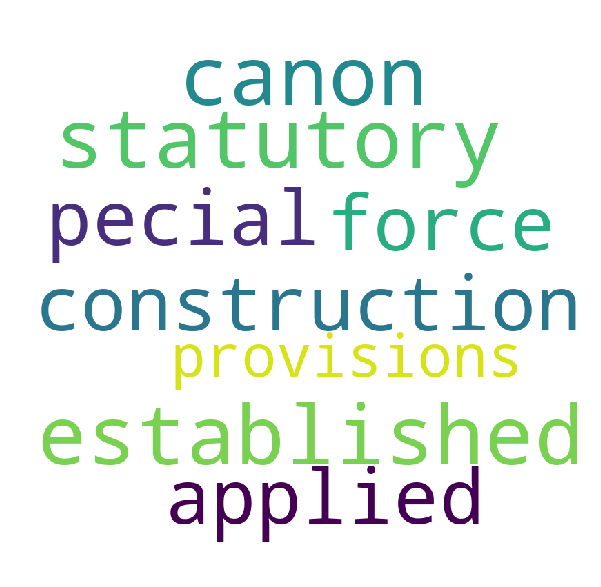

In [32]:
bow_features=bow.get_feature_names()
# w is the weight after fitting the model
feature_importances = pd.DataFrame(w,index = preprocessed_reviews, columns=['importance']).sort_values('importance',ascending=False)

a=feature_importances.iloc[0:1]
comment_words = ' '
for val in a.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [51]:
len(bow_features)

10018

#### TFIDF Vectorization

In [20]:
X=preprocessed_reviews[:]
# y=final['Score'][:]
# X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=42)
X_train=preprocessed_reviews[:13000]
X_test=preprocessed_reviews[13000 :]
# bow = TfidfVectorizer()
# X_train_bow=bow.fit_transform(X_train)
# X_test_bow=bow.transform(X_test)

tfidf = TfidfVectorizer()
X_train_tfidf=tfidf.fit_transform(X_train)
X_test_tfidf=tfidf.transform(X_test)
tfidf_features=tfidf.get_feature_names()

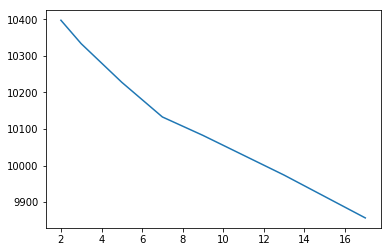

In [21]:
errors=[]
k_value=[2,3,5,7,9, 13,  17]
for i in k_value:
    kmeans = KMeans(n_clusters=i, random_state=0, n_jobs=-1)
    kmeans.fit(X_train_tfidf)
    pred=kmeans.predict(X_test_tfidf)
    errors.append(kmeans.inertia_)
plt.plot(k_value, errors)
plt.show()

In [26]:
scaler = StandardScaler()
model=KMeans(n_clusters=7, n_jobs=-1)
z=tfidf.fit_transform(X_train)
model.fit(scaler.fit_transform(z.toarray()))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [39]:
w=model.labels_

In [40]:
len(w)

13000

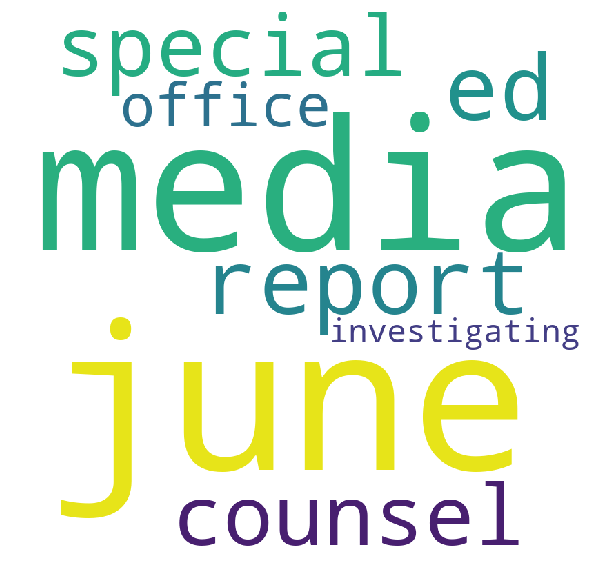

In [43]:
# tfidf_features=tfidf.get_feature_names()
# w is the weight after fitting the model
feature_importances = pd.DataFrame(w,index = X_train, columns=['importance']).sort_values('importance',ascending=False)

a=feature_importances.iloc[10:11]
comment_words = ' '
for val in a.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### Using Word2Vec vectorizations

In [46]:
from gensim.models import Word2Vec
import gensim

In [47]:
list_sent=[]
for sent in preprocessed_reviews:
    list_sent.append(sent.split())

w2v_model=gensim.models.Word2Vec(X_train,min_count=5, size=50)
w2v_words = list(w2v_model.wv.vocab)
# Then vectorize your train model as
sent_vectors_train = [];
for sent in tqdm(X_train):
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
# And then vectorize test as
sent_vectors_test = [];
for sent in tqdm(X_test):
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent: #
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)

100%|████████████████████████████████████████████████████████████████████████████| 5747/5747 [00:01<00:00, 4525.83it/s]


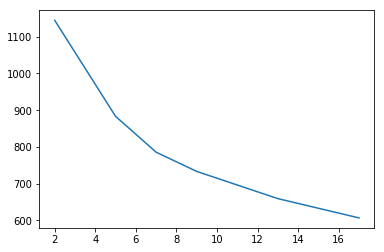

In [48]:
errors=[]
k_value=[2,5,7,9,13, 17]
for i in k_value:
    kmeans = KMeans(n_clusters=i, random_state=0, n_jobs=-1)
    kmeans.fit(sent_vectors_train)
    pred=kmeans.predict(sent_vectors_test)
    errors.append(kmeans.inertia_)
plt.plot(k_value, errors)
plt.show()

In [51]:
model=KMeans(n_clusters=9, n_jobs=-1)
# z=tfidf.fit_transform(pr)
model.fit(sent_vectors_train)
w=model.labels_

In [56]:
len(w)

13000

In [58]:
list_sent=[]
for sent in preprocessed_reviews:
    list_sent.append(sent.split())
X=preprocessed_reviews[:]
# y=final['Score'][:]
# X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=42)

w2v_model=gensim.models.Word2Vec(X_train,min_count=5, size=50)
w2v_words = list(w2v_model.wv.vocab)
# Then vectorize your train model as
sent_vectors_train = [];
for sent in tqdm(X_train):
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
# And then vectorize test as
sent_vectors_test = [];
for sent in tqdm(X_test):
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent: #
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)

100%|████████████████████████████████████████████████████████████████████████████| 5747/5747 [00:01<00:00, 4383.72it/s]


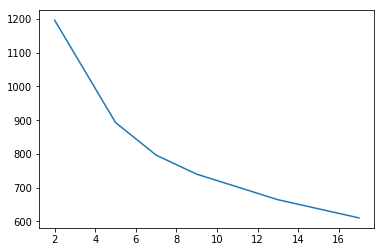

In [59]:
errors=[]
k_value=[2,5,7,9,13, 17]
for i in k_value:
    kmeans = KMeans(n_clusters=i, random_state=0, n_jobs=-1)
    kmeans.fit(sent_vectors_train)
    pred=kmeans.predict(sent_vectors_test)
    errors.append(kmeans.inertia_)
plt.plot(k_value, errors)
plt.show()

In [66]:
model=KMeans(n_clusters=7, n_jobs=-1)
z=tfidf.fit_transform(X_train)
model.fit(scaler.fit_transform(z.toarray()))
w=model.labels_

In [67]:
len(w)

13000

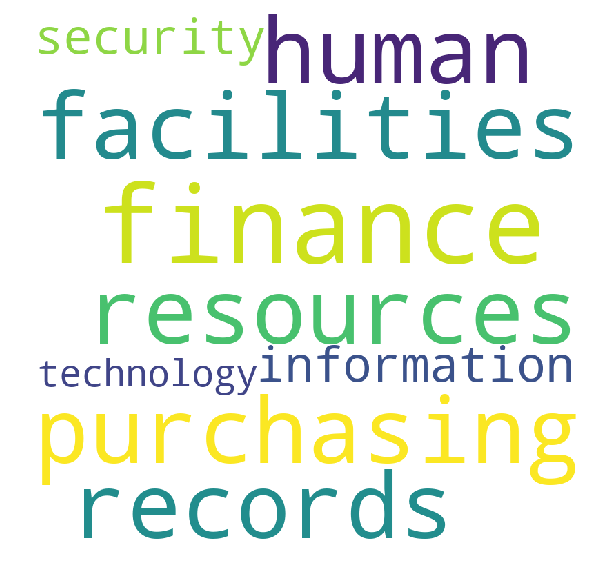

In [72]:
feature_importances = pd.DataFrame(w,index = preprocessed_reviews[:len(w)], columns=['importance']).sort_values('importance',ascending=False)
a=feature_importances.iloc[0:1]
comment_words = ' '
for val in a.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()